In [1]:
############********** Project Training File **********############


import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime, timedelta, date

# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.datasets import make_classification
from sklearn_pandas import CategoricalImputer
#from feature_engine.imputation import CategoricalImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot
import datetime as dt
import matplotlib.pyplot as plt
from datetime import date
import holidays
import scipy.stats as stats
from scipy.stats import norm
pd.set_option("display.max_columns", None)


In [2]:
df= pd.read_csv('project_data_sla.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'ID', 'SharePointID', 'ProjectColor', 'ProjectName',
       'ProjectType', 'CreateDate', 'CreatedBy', 'PlanStartDate',
       'PlanFinishDate', 'StatusDate', 'ProjectDescription', 'DollarAmount',
       'Status', 'WorkPerformedFor', 'RefrenceNumber', 'ProjectStage',
       'CancelationReason', 'BuyerName', 'Hours', 'SensitivityIndicator',
       'Division', 'SourcingCategory', 'ActualFinishDate', 'Unit', 'SLA',
       'Planned', 'SolicitationStatus', 'LastUpdatedBy', 'LastUpdateDate',
       'LastUpdatedField', 'CategoryID', 'FedReview', 'ITComponent',
       'SolicitationNum', 'LevelCalc'],
      dtype='object')

In [4]:
df['PlanStartDate']=pd.to_datetime(df['PlanStartDate'])
df['ActualFinishDate']=pd.to_datetime(df['ActualFinishDate'])

In [5]:
df.dtypes

Unnamed: 0                       int64
ID                               int64
SharePointID                     int64
ProjectColor                    object
ProjectName                     object
ProjectType                     object
CreateDate                      object
CreatedBy                       object
PlanStartDate           datetime64[ns]
PlanFinishDate                  object
StatusDate                      object
ProjectDescription              object
DollarAmount                   float64
Status                          object
WorkPerformedFor                 int64
RefrenceNumber                  object
ProjectStage                    object
CancelationReason                int64
BuyerName                       object
Hours                          float64
SensitivityIndicator              bool
Division                        object
SourcingCategory                object
ActualFinishDate        datetime64[ns]
Unit                           float64
SLA                      

# Data Preparation and Cleansing 

In [6]:
###--- Data pre-processing and cleaning for training model---###

def prepare_df2(df):
    
    #Calculating the duration
    df = df.reset_index()
    df = df.dropna(subset=['PlanFinishDate'])
    mi_holidays = holidays.UnitedStates(state='MI')
    start = df['PlanStartDate'].astype(str)
    end = df['ActualFinishDate'].astype(str)
    bus = []
    holi = []
    dur = []
    start_list = start.tolist()
    end_list = end.tolist()
    for i in range(len(start_list)):
        holi.append(len(mi_holidays[start_list[i]: end_list[i]]))
        bus.append(np.busday_count(start_list[i], end_list[i]))

    zip_object = zip(bus, holi)
    for list1_i, list2_i in zip_object:
        dur.append(list1_i-list2_i)
    df['dur'] = dur
    variables_to_remove = ['index','SharePointID', 'ID', 'ProjectName', 'CreateDate', 'PlanStartDate',
             'PlanFinishDate', 'StatusDate', 'ProjectDescription', 'Status', 'StatusDate', 'ProjectDescription',
             'Status', 'RefrenceNumber', 'CancelationReason', 'ActualFinishDate', 'Unit',
             'SolicitationStatus', 'LastUpdatedBy', 'LastUpdateDate', 'LastUpdatedField', 'SolicitationNum',
             'SensitivityIndicator', 'SourcingCategory', 'DollarAmount'] # Business requested removal of the following features

    df = df.drop(variables_to_remove, axis = 1)
    df = df.rename(columns={"dur": "Duration"})
    df = df[df["Duration"]>0]
    # handling NaN values
    imputer = CategoricalImputer()
    data = np.array(df['Planned'], dtype=object)
    data2 = np.array(df['CreatedBy'], dtype=object)
    data3 = np.array(df['BuyerName'], dtype=object)

    df['Planned'] = imputer.fit_transform(data)
    df['CreatedBy'] = imputer.fit_transform(data2)
    df['BuyerName'] = imputer.fit_transform(data3)
    df = df.dropna()
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    return df

def met_sla(df):
    
    if df['Duration'] <= df['SLA']:
        val = 1
    elif df['Duration'] > df['SLA']:
        val = 0
    return val

model2_df = prepare_df2(df)
model2_df['Met_SLA'] = model2_df.apply(met_sla, axis=1)
model2_df.head()


,Unnamed: 0,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,ProjectStage,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Duration,Met_SLA
0,2,Green,CN,keilenn,71,Complete,JY1,0.0,PROF,63,Yes,50,False,False,3.0,5,1
1,3,Green,RFP,Gibrilm,0,Complete,YMD,120.0,COMM,138,Yes,185,False,False,2.0,54,1
2,4,Green,RFP,Gibrilm,0,Complete,YMD,120.0,COMM,138,No,184,False,False,3.0,58,1
3,6,Green,RFP,Gibrilm,591,Complete,YMD,120.0,COMM,138,No,301,False,False,2.0,101,1
4,11,Green,RFP,Gibrilm,431,Complete,SR4,120.0,COMM,138,No,143,False,False,4.0,172,0


In [40]:
def graph(df,project_type, fy = None, division = None):
    if fy:
        df=df[(df['ActualFinishDate']>=pd.to_datetime('10/1/'+str(fy-1))) &\
              (df['ActualFinishDate']<=pd.to_datetime('09/30/'+str(fy)))]
    if division:
        df = df[df['Division']==division]
        
    df = df[df['ProjectType'].isin(project_type)]
    df =df[df['ProjectStage'] == 'Complete']
    df = df.sort_values(by = 'Duration')
    x = df['Duration']
    sla=df['SLA'].mean()
    
    ax = sns.distplot(x,bins=15, hist=True, fit=norm,kde=True,color=None)#sns.kdeplot(x, shade=False, color='lightblue',gridsize=100)
    sns.set(rc={'figure.figsize':(6,7)})
    kdeline = ax.lines[0]
    median = x.median()
    sdt = x.std()
    print(sdt)
    mean = x.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(median, xs, ys)
    height_m = np.interp(mean, xs, ys)
    height_d = np.interp(sla, xs, ys)
    ax.vlines(median, 0, height, color='crimson', ls=':')#,#label='Median '+str(round(median,0)))
    ax.vlines(mean, 0, height_m, color='green', ls='--',label='Average '+str(round(mean,0)))
    ax.vlines(sla, 0, height_d, color='black', ls='-.',label='SLA')
    ax.fill_between(xs, 0, ys, facecolor='lightblue', alpha=0.3)
    ax.set_title('Duration Distribuation for ' + str(project_type) + '\n'+'Number of projects: '\
                 + str(df['ProjectType'].count())+'\n'\
                 +'Max Duration '+ str(max(x))+' - Min Duration '\
                 + str(min(x)),fontdict= { 'fontsize': 12, 'fontweight':'bold'} )
    ax.grid(linestyle='-', linewidth='0.5', color='lightgray')
    ax.set(xlabel='Duration', ylabel='Density Function')
    ax.set_facecolor('#F8F6F6')
    ax.legend(['Normal Distribuation','Median '\
               +str(round(median,0)),'Average '+\
               str(round(mean,0)),'SLA '+str(sla),'Kernel Density Estimation'])
    return None

In [41]:
fy = None
project_type = ['CN', 'RFP', 'C-RFP', 'CO-OP', 'ITN', 'DS', 'CPC']

64.2994093625592


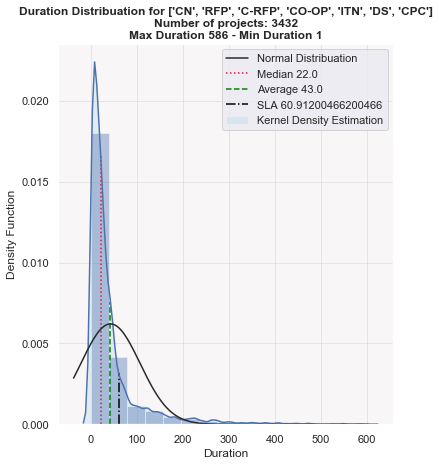

In [42]:
graph(prepare_df2(df),project_type)

In [10]:
def distribuation(df,p_type=[],fy=None,division = None):
    if fy:
        df=df[(df['ActualFinishDate']>=pd.to_datetime('10/1/'+str(fy-1))) &\
              (df['ActualFinishDate']<=pd.to_datetime('09/30/'+str(fy)))]
    if division:
        df = df[df['Division']==division]
    df = df[df['ProjectType'].isin (p_type)]
    normal_distr_values  = df['Duration']
    plus_one_std_dev = np.mean(normal_distr_values) + np.std(normal_distr_values)
    minus_one_std_dev = np.mean(normal_distr_values) - np.std(normal_distr_values)

    ###
    stats.probplot(normal_distr_values, dist="norm", fit=True, rvalue=True, plot=plt)
    ###
    plt.xlabel("Theoretical quantiles\nStandard Deviations", labelpad=15)
    plt.title("Probability Plot to Compare Duration Distribution to Perfectly Normal Distribution\n Project Type: "\
              + str(p_type) +' # projects: '+str(len(normal_distr_values))\
              + ' max: '+str(max(normal_distr_values))+ ' min: '+str(min(normal_distr_values)) , y=1.015)
    return len(df)

3432

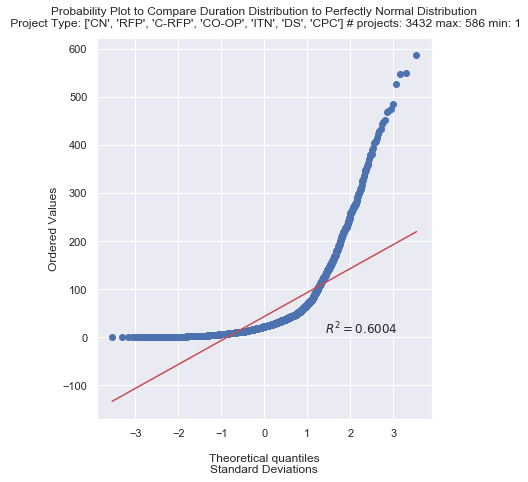

In [39]:
distribuation(prepare_df2(df),project_type)

# Creating Labels for Different durations

In [12]:
#putting duration ranges into categories

duration = []
for item in model2_df['Duration'].to_list():
    if abs(int(item)) >=0 and abs(int(item)) < 50:
        duration.append(1)
    elif abs(int(item)) >=50 and abs(int(item)) < 100:
        duration.append(2)
    elif abs(int(item)) >=100 and abs(int(item)) < 150:
        duration.append(3)
    elif abs(int(item)) >=150 and abs(int(item)) < 200:
        duration.append(4)
    elif abs(int(item)) >=200 and abs(int(item)) < 250:
        duration.append(5)
    elif abs(int(item)) >=250 and abs(int(item)) < 300:
        duration.append(6)
    elif abs(int(item)) >=300 and abs(int(item)) < 350:
        duration.append(7)
    elif abs(int(item)) >=350 and abs(int(item)) < 400:
        duration.append(8)
    elif abs(int(item)) >=400:
        duration.append(9)

#creating duration category column
model2_df['DurationCat'] = duration
model2_df = model2_df.drop(['Duration'], axis = 1)

print(model2_df.shape)
model2_df= model2_df.drop(['Unnamed: 0'], axis = 1)
model2_df.head()


(3434, 17)


,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,ProjectStage,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Met_SLA,DurationCat
0,Green,CN,keilenn,71,Complete,JY1,0.0,PROF,63,Yes,50,False,False,3.0,1,1
1,Green,RFP,Gibrilm,0,Complete,YMD,120.0,COMM,138,Yes,185,False,False,2.0,1,2
2,Green,RFP,Gibrilm,0,Complete,YMD,120.0,COMM,138,No,184,False,False,3.0,1,2
3,Green,RFP,Gibrilm,591,Complete,YMD,120.0,COMM,138,No,301,False,False,2.0,1,3
4,Green,RFP,Gibrilm,431,Complete,SR4,120.0,COMM,138,No,143,False,False,4.0,0,4


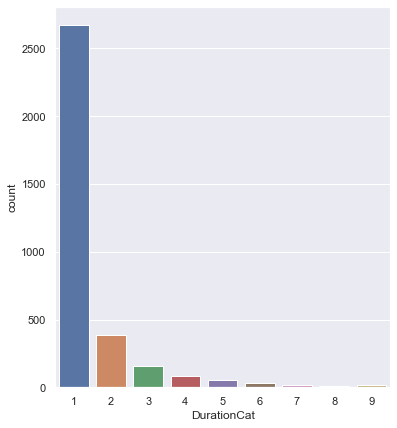

In [13]:
sns.countplot(model2_df['DurationCat'],label="Count")

In [14]:
model2_df.columns

Index(['ProjectColor', 'ProjectType', 'CreatedBy', 'WorkPerformedFor',
       'ProjectStage', 'BuyerName', 'Hours', 'Division', 'SLA', 'Planned',
       'CategoryID', 'FedReview', 'ITComponent', 'LevelCalc', 'Met_SLA',
       'DurationCat'],
      dtype='object')

# Feature Selection 

In [15]:
X = model2_df[['ProjectColor', 'ProjectType', 'CreatedBy',  'WorkPerformedFor', 'BuyerName', 'Hours', 'Division', 'SLA', 'Planned',
         'CategoryID', 'FedReview', 'ITComponent', 'LevelCalc', 'Met_SLA']]
y = model2_df['DurationCat']

In [16]:
from matplotlib import pyplot as plt

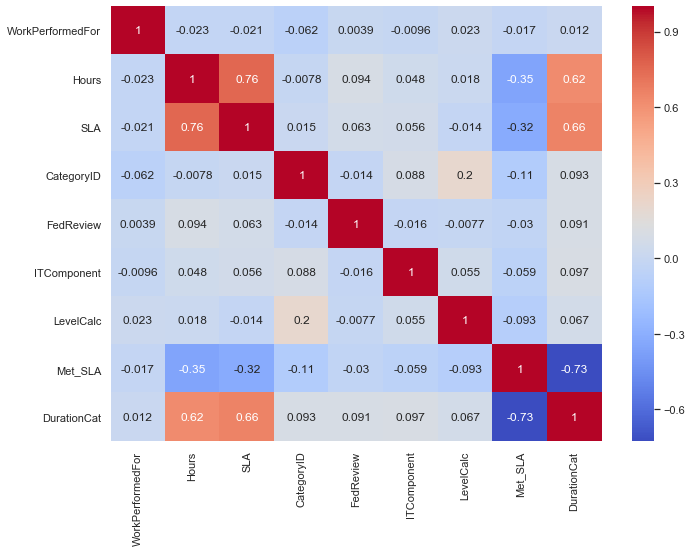

In [17]:
corr = model2_df.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="coolwarm",annot=True)
plt.show()

In [18]:
###--- Functions that prepares data for model--> turns data entries to a form the model can read ---###

def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value= -1)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X = model2_df.iloc[:, :-1]
y = model2_df.iloc[:,-1]
    # format all fields as string
X = X.astype(str)
np.set_printoptions(threshold=sys.maxsize)
num = 0
feature_name = []
for i in X:
    print("Feature number: "+str(num)+" "+str(i))
    num+=1
    feature_name.append(i)

Feature number: 0 ProjectColor
Feature number: 1 ProjectType
Feature number: 2 CreatedBy
Feature number: 3 WorkPerformedFor
Feature number: 4 ProjectStage
Feature number: 5 BuyerName
Feature number: 6 Hours
Feature number: 7 Division
Feature number: 8 SLA
Feature number: 9 Planned
Feature number: 10 CategoryID
Feature number: 11 FedReview
Feature number: 12 ITComponent
Feature number: 13 LevelCalc
Feature number: 14 Met_SLA


In [19]:
###--- Running algorithm that selects the best features ---###


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection



In [20]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_score = MIC(X_train_enc,y_train_enc)
for i in mi_score:
    print(round(i,2))

0.0
0.15
0.05
0.0
0.0
0.04
0.14
0.02
0.15
0.01
0.05
0.0
0.01
0.01
0.33


In [21]:
df_featur_selection = pd.DataFrame()
df_featur_selection['Feature_Name'] = feature_name
df_featur_selection['mi_scores'] = mi_score
df_featur_selection = df_featur_selection.sort_values(by ='mi_scores',ascending=False )

df_featur_selection

,Feature_Name,mi_scores
14,Met_SLA,0.334500
1,ProjectType,0.149997
8,SLA,0.148692
6,Hours,0.141379
2,CreatedBy,0.047349
10,CategoryID,0.045717
5,BuyerName,0.039908
7,Division,0.020789
13,LevelCalc,0.013674
9,Planned,0.007894


In [22]:
remove_lst = df_featur_selection[df_featur_selection['mi_scores']<0.01].index
remove_lst

Int64Index([9, 12, 11, 0, 3, 4], dtype='int64')

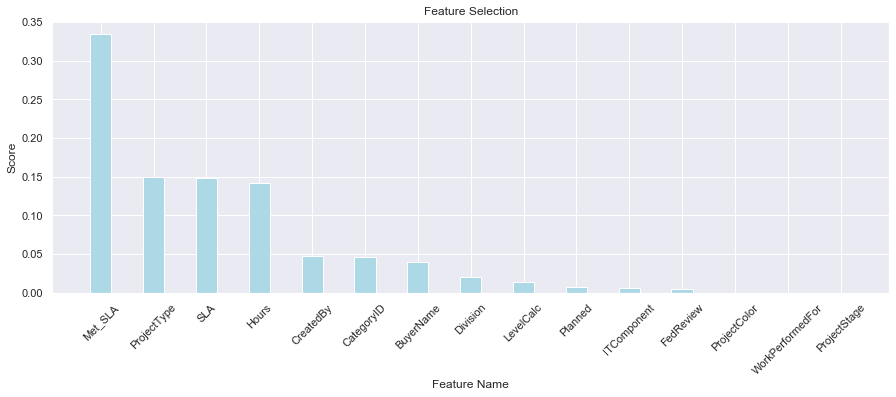

In [23]:
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
bar = plt.bar(df_featur_selection['Feature_Name'], df_featur_selection['mi_scores'], color ='lightblue',
        width = 0.4)
plt.xticks(rotation = 45)
plt.xlabel("Feature Name")
plt.ylabel("Score")
plt.title("Feature Selection")
plt.show()

# Bias handling and Model Selection 

In [24]:
X_train_enc = np.delete(X_train_enc, np.s_[remove_lst], 1)
X_test_enc = np.delete(X_test_enc, np.s_[remove_lst], 1)

In [25]:
oversample = SMOTE(random_state=42, sampling_strategy={0:2500, 1:2500, 2:2000, 3:2000, 4:2000, 5:2000, 6:2000, 8:2000})
X_s, y_s = oversample.fit_resample(X_train_enc, y_train_enc)

C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

In [26]:
def ave_score(model):
    scores=[]
    for i in range(10):
        model.fit(X_s, y_s)
        score = model.score(X_test_enc, y_test_enc)
        scores.append(score)
    return sum(scores)/len(scores)
    

In [27]:
#ave_score(RandomForestClassifier(n_estimators=1000))

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
result_df = pd.DataFrame()

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]
random_state=42
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025,random_state=random_state),
    SVC(gamma=2, C=1,random_state=random_state),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=7, n_estimators=1000, max_features=1,random_state=random_state),
    MLPClassifier(alpha=1, max_iter=1000,random_state=random_state),
    AdaBoostClassifier(random_state=random_state),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

name_lst= []
result_model=[]
for name, clf in zip(names, classifiers):
            clf.fit(X_s, y_s)
            score = clf.score(X_test_enc, y_test_enc)
            name_lst.append(name)
            result_model.append(score)
            print(name, score)
        
       
result_df['model Name'] = name_lst
result_df['score'] = result_model

result_df

Nearest Neighbors 0.671957671957672
Linear SVM 0.8694885361552028
RBF SVM 0.5608465608465608
Decision Tree 0.8783068783068783
Random Forest 0.8756613756613757
Neural Net 0.8492063492063492
AdaBoost 0.11992945326278659
Naive Bayes 0.8024691358024691
QDA 0.7698412698412699


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:903: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:903: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:906: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


,model Name,score
0,Nearest Neighbors,0.671958
1,Linear SVM,0.869489
2,RBF SVM,0.560847
3,Decision Tree,0.878307
4,Random Forest,0.875661
5,Neural Net,0.849206
6,AdaBoost,0.119929
7,Naive Bayes,0.802469
8,QDA,0.769841


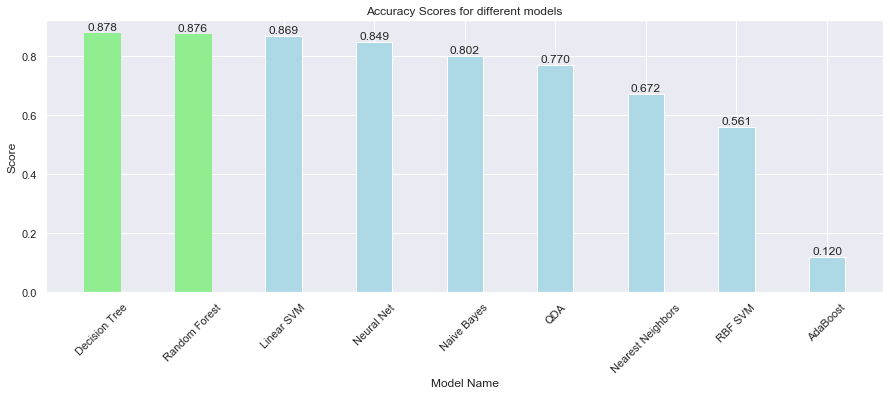

In [29]:
result_df = result_df.sort_values(by= 'score',ascending=False )

fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
bar = plt.bar(result_df['model Name'], result_df['score'], color ='lightblue',
        width = 0.4)
plt.xticks(rotation = 45)
plt.xlabel("Model Name")
plt.ylabel("Score")
plt.title("Accuracy Scores for different models")

for x,y in zip(result_df['model Name'], result_df['score']):

    label = "{:.3f}".format(y)
    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,3), 
                 ha='center') 
bar[0].set_color('lightgreen')
bar[1].set_color('lightgreen')
#plt.text(4.5,.85,'Random Forest Classifier'+str(max(result_df['score'])))
plt.show()

In [30]:
max_depth_dt = []
scores_dt = []
for i in range(1,20):
    model = DecisionTreeClassifier(max_depth=i,random_state=random_state)
    model = model.fit(X_s, y_s)
    score = model.score(X_test_enc, y_test_enc)
    max_depth_dt.append(i)
    scores_dt.append(score)


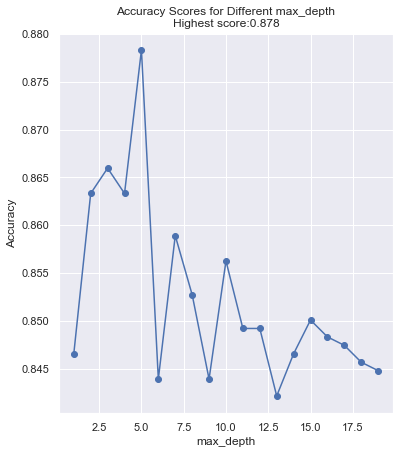

In [31]:
plt.plot(max_depth_dt,scores_dt,marker='o')
plt.title('Accuracy Scores for Different max_depth'+'\n' 'Highest score:' +str(round(max(scores_dt),3)))
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

In [32]:
model = DecisionTreeClassifier(max_depth=5,random_state=random_state)
model = model.fit(X_s, y_s)
    # evaluate the model
score = model.score(X_test_enc, y_test_enc)
   
print('Accuracy: %.3f' % (score))

Accuracy: 0.878


In [33]:
max_depth_rf = []
scores_rf = []
for i in range(1,20):
    model = RandomForestClassifier(max_depth=i, n_estimators=1000, max_features=1,random_state=random_state)
    model = model.fit(X_s, y_s)
    score = model.score(X_test_enc, y_test_enc)
    max_depth_rf.append(i)
    scores_rf.append(score)

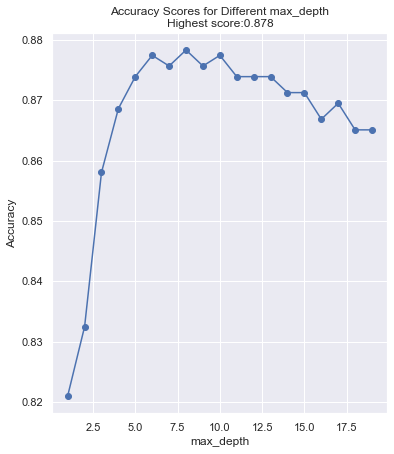

In [34]:
line=plt.plot(max_depth_rf,scores_rf,marker='o')
plt.title('Accuracy Scores for Different max_depth'+'\n' 'Highest score:' +str(round(max(scores_rf),3)))
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

In [35]:
model = RandomForestClassifier(max_depth=6, n_estimators=100, max_features=1,random_state=random_state)
model = model.fit(X_s, y_s)
score = model.score(X_test_enc, y_test_enc)

print(score)

0.8703703703703703


In [36]:
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

#run algorithm multiple times to get desired accuracy
desired_accu = 0
while desired_accu < 0.88:

    
    #oversample training data to avoid skewness
    oversample = SMOTE(random_state=42, sampling_strategy={0:2500, 1:2500, 2:2000, 3:2000, 4:2000, 5:2000, 6:2000, 8:2000})
    X_s, y_s = oversample.fit_resample(X_train_enc, y_train_enc)
    #X_test = X_test.to_numpy()

    model = RandomForestClassifier(max_depth=6,n_estimators=1000,random_state=random_state)

    model = model.fit(X_s, y_s)
    # evaluate the model
    scores = evaluate_model(X_test_enc, y_test_enc, model)
    desired_accu = np.mean(scores)
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.877 (0.012)


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.876 (0.013)


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.879 (0.013)


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.878 (0.008)


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.877 (0.012)


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.876 (0.011)


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.878 (0.014)


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1801)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.881 (0.016)


In [37]:
filename = 'model2try1.sav'
pickle.dump(model, open(filename, 'wb'))